## Подключаемся к Yandex AI Studio / Yandex Cloud

В этом ноутбуке мы рассмотрим три примера использования Yandex AI Studio через API:

1. **Генерация текста через Yandex AI Studio SDK** - генерация текста с помощью модели YandexGPT в Yandex AI Studio SDK
2. **Yandex ART** - генерация изображений
3. **Responses API** - использование LLM через OpenAI-совместимый Responses API

Для начала установим необходимые библиотеки:

In [ ]:
%pip install --upgrade yandex-ai-studio-sdk openai python-dotenv Pillow

**ВНИМАНИЕ**: После установки библиотек рекомендуется перезапустить Kernel ноутбука.

Также определим полезную функцию для отображения результатов в формате Markdown:

In [1]:
from IPython.display import Markdown, display, Image

def printx(string):
    display(Markdown(string))

## Авторизация

Для работы с сервисами Yandex AI Studio через программный интерефейс API нам понадобится ключ доступа `api_key` и идентификатор каталога в облаке `folder_id`.

В коде ниже предполагается, что эти значения хранятся в переменных окружения, либо автоматически загружаются из файла `.env`, в котором они прописаны следующим образом:
```
folder_id=...
api_key=...
````

Перед выполнением кода вам необходимо поместить соответствующий файл в текущий каталог. В зависимости от того, проходите ли вы курс самостоятельно или с преподавателем, вы можете получить данные для авторизации разными способами:

* Зарегистрироваться в Yandex AI Studio самостоятельно
* Зарегистрироваться в Yandex Cloud и получить приветственный грант на использование облака. После этого:
  - создать сервисный аккаунт, от имени которого бы будете вызывать все сервисы. У аккаунта должны быть роли `ai.editor` и `serverless.mcpGateway.invoker`, или же можно сразу назначить самую разрешающую роль `editor` или `admin`.
  - для сервисного аккаунта создать API-ключ доступа
* Получить от преподавателя файл `.env` со всеми необходимыми значениями и поместить его в текущую директорию. Если преподаватель поделился с вами URL-ссылкой на файл, то загрузить его можно, выполнив ячейку ниже (при необходимости руками подставив ссылку вместо `{{url_of_dotenv_file}}`):

In [ ]:
!curl -o .env {{url_of_dotenv_file}}\n

Теперь загрузим значения в переменные `folder_id` и `api_key`, которыми мы будем пользоваться в дальнейшем.

> Вы также можете установить значения `folder_id` и `api_key` прямо в коде на Python, если Вам так понятнее. Но обычно так делать не рекомендуют, чтобы ключи не попали к третьим лицам, если вы будете делиться кодом.

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

folder_id = os.environ["folder_id"]
api_key = os.environ["api_key"]

print(f"Folder ID: {folder_id[:8]}...")

Folder ID: b1gbicod...


---

## Пример 1: Вызываем YandexGPT через Yandex AI Studio SDK

[Yandex AI Studio SDK](https://github.com/yandex-cloud/yandex-ai-studio-sdk) предоставляет удобный Python-интерфейс для работы со всеми сервисами AI Studio. Для начала посмотрим, как можно вызвать языковую модель.

Определим класс, через который будем общаться с SDK:

In [4]:
from yandex_ai_studio_sdk import AIStudio

# Создаем SDK-клиент
sdk = AIStudio(
    folder_id=folder_id,
    auth=api_key,
)

Попросим модель рассказать шутку:

In [7]:
# Получаем модель YandexGPT
model = sdk.models.completions('yandexgpt')

# Генерируем ответ
result = model.configure(
    temperature=0.7,
).run("Расскажи смешную шутку про программистов.")

for alternative in result:
    printx(alternative.text)

Два программиста разговаривают:

— Как тебя зовут?
— Вася.
— А я думал, тебя зовут Error_404.
— Почему?
— Потому что тебя не существует! Ты null!

---

## Пример 2: Генерация изображений с YandexART

YandexART — это модель генерации изображений по текстовому описанию. Поскольку создание изображения занимает некоторое время, это происходит в **асинхронном режиме**:
* Мы подаём запрос на рисование
* Затем ожидаем окончания (или можем периодически запрашивать, не готово ли)

Создадим изображение с YandexART:

Генерация изображения...
Изображение сгенерировано!


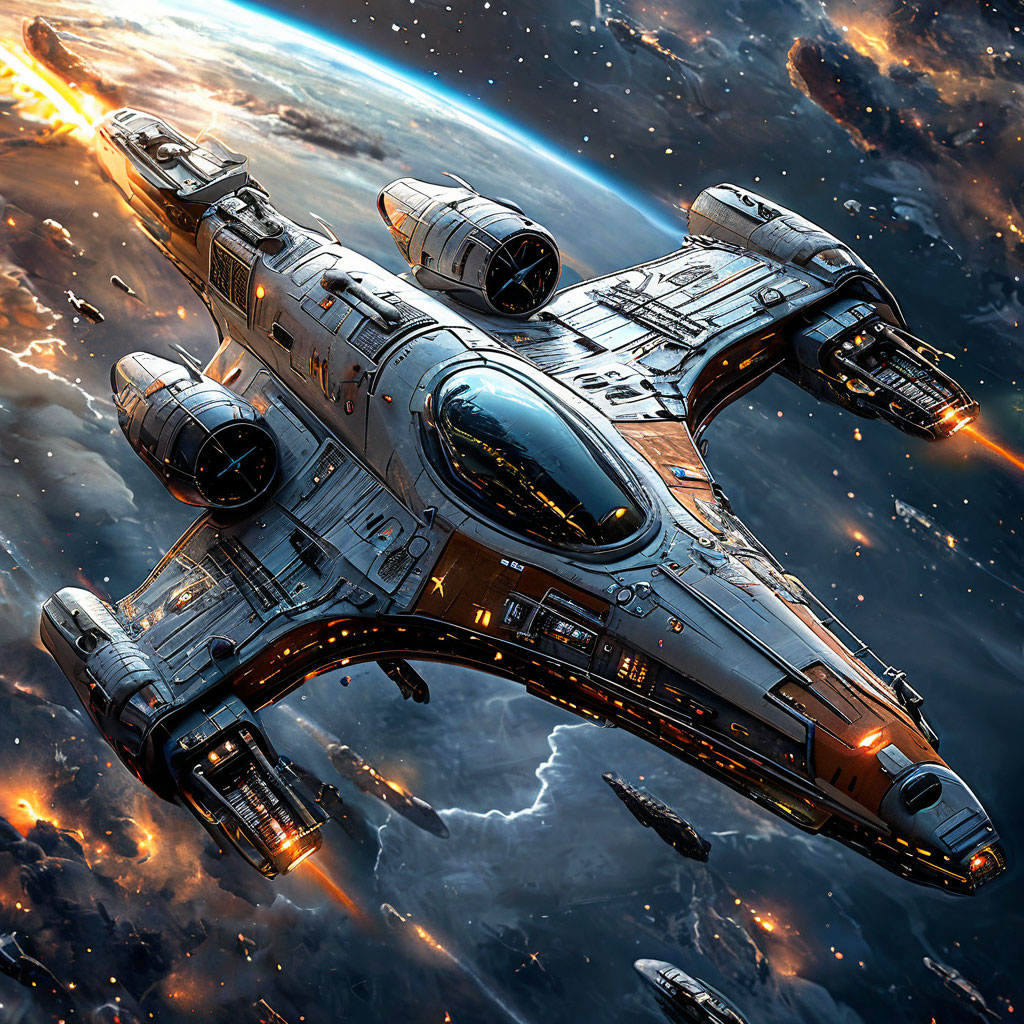

In [8]:
from PIL import Image as PILImage
import io

# Получаем модель Yandex ART
model = sdk.models.image_generation('yandex-art')

# Настраиваем параметры генерации
model = model.configure(width_ratio=1, height_ratio=1)

# Запускаем генерацию (асинхронная операция)
print("Генерация изображения...")
operation = model.run_deferred(['Красивый космический корабль', 'в стиле научной фантастики'])
result = operation.wait()

print("Изображение сгенерировано!")

# Отображаем изображение
image = PILImage.open(io.BytesIO(result.image_bytes))
display(image)

Асинхронный режим можно использовать и для текстовых моделей - в этом случае облако может более продуманно распределить ресурсы, и поэтому стоимость асихнронного режима ниже. Его можно использовать в том случае, если необходимо обработать большие объемы текста, и при этом нет жестких ограничений по времени. 

Также есть пакетный режим, в котором доступно большое количество моделей, запускаемых по запросу для обработки ваших данных. [Пример](https://github.com/yandex-cloud/yandex-ai-studio-sdk/blob/master/examples/sync/batch/manage.py) того, как используется пакетный режим, а также множество других полезных примеров использования, можно найти [в репозитории AI Studio SDK](https://github.com/yandex-cloud/yandex-ai-studio-sdk/blob/master/examples/).

---

## Пример 3: Responses API с OpenAI SDK

Yandex AI Studio поддерживает режим совместимости с OpenAI, что позволяет использовать все общедоступные библиотеки, работающие с OpenAI, такжи и в Yandex AI Studio. Именно такой подход к работе с языковыми моделями стоит использовать, поскольку ваш код можно будет легко адаптировать под другие облачные провайдеры.

OpenAI предоставляет, я Yandex AI Studio поддерживает, несколько протоколов: Chat Completion API и Responses API. Именно Responses API является наиболее современным способом взаимодействия с LLM и построения агентских систем, поэтому мы будем рассматривать в курсе именно его.

Для работы будем использовать стандартный OpenAI SDK, передавая ему соответствующий параметр `base_url` (он определяет, куда именно будут посылаться вызовы к моделям), ключ авторизации `api_key` и имя модели.

> **ВАЖНО**: Для правильной работы со всеми функциями Responses API необходимо передать `folder_id` в параметр `project` при создании объекта OpenAI SDK.

In [9]:
from openai import OpenAI

# Указываем модель
model_uri = f"gpt://{folder_id}/yandexgpt/rc"

# Создаем клиент OpenAI с настройками для Yandex Cloud
client = OpenAI(
    base_url="https://ai.api.cloud.yandex.net/v1",
    api_key=api_key,
    project=folder_id
)

# Отправляем запрос
res = client.responses.create(
    model=model_uri,
    instructions="Ты — остроумный комик, который рассказывает шутки в стиле stand-up.",
    input="Расскажи смешную шутку про искусственный интеллект."
)

printx(res.output_text)

Знаете, что говорит искусственный интеллект, когда ему надоедает работать? «Я просто хочу лежать на диване, смотреть сериалы и есть пиццу, как обычный человек!» Правда, пиццу он, наверное, заказывал бы через себя же — ведь он слишком умён, чтобы пользоваться другими способами.

Обратите внимание, что при указании имени модели мы также добавили в это имя идентификатор каталога `folder_id`. В примере мы использовали YandexGPT, но можно было бы выбрать и другую модель. Список доступных моделей [есть в документации](https://yandex.cloud/ru/docs/ai-studio/concepts/generation/models).

### Продолжение диалога

При осмысленном общении с ИИ важно поддерживать диалог - а для этого нужно каждый раз подавать на вход модели всю цепочку предыдущих сообщений. Это можно делать тремя способами:

* Накапливая цепочку сообщений вручную в виде списка, и каждый раз передавая в модель
* Используя явный объект `conversation` для хранения диалога
* Передавая в каждый следующий запрос `id` предыдущего ответа в параметре `previous_response_id`:

In [10]:
# Первый запрос с сохранением истории
res = client.responses.create(
    model=model_uri,
    store=True,  # Сохраняем историю для продолжения диалога
    instructions="Ты — весёлый ассистент, который отвечает с юмором.",
    input="Привет! Как дела?"
)

printx(f"**Ассистент:** {res.output_text}")
print(f"\nID ответа: {res.id}")

# Продолжение диалога
res2 = client.responses.create(
    model=model_uri,
    store=True,
    previous_response_id=res.id,
    input="Расскажи что-нибудь интересное про облака!"
)

printx(f"\n**Ассистент:** {res2.output_text}")

**Ассистент:** Привет! У меня всё супер, словно я выиграл лотерею! А у тебя как дела?


ID ответа: 6504648a-5a5f-45e7-ae15-bd0f0dde0663



**Ассистент:** Облака — это не просто белоснежные «барашки» на небе. Вот несколько интересных фактов о них:

1. **Разнообразие форм и видов.** Облака бывают самых разных форм и видов. Существует несколько основных типов облаков: кучевые, слоистые, перистые и другие. Они различаются по внешнему виду, высоте расположения и даже по «поведению». Например, кучевые облака часто предвещают грозу, а перистые могут указывать на изменения в погоде на больших высотах.

2. **Образование облаков.** Облака образуются, когда тёплый влажный воздух поднимается вверх, охлаждается и конденсируется вокруг частиц пыли, соли или других мелких частиц. Этот процесс похож на то, как образуется пар над чашкой горячего чая.

3. **Роль в погоде и климате.** Облака играют ключевую роль в погоде и климате Земли. Они влияют на температуру поверхности планеты, отражая солнечные лучи и удерживая тепло. Также они являются необходимым условием для выпадения осадков, будь то дождь, снег или град.

4. **Облака на других планетах.** Не только на Земле есть облака! На других планетах и их спутниках тоже есть облака, но они могут состоять из совсем других веществ. Например, на Венере облака состоят из серной кислоты, а на некоторых спутниках Юпитера и Сатурна — из аммиака или метана.

5. **Необычные виды облаков.** Иногда можно увидеть довольно редкие и необычные виды облаков. Например, лентикулярные облака, которые часто образуются возле гор и выглядят как летающие тарелки, или перламутровые облака, которые можно наблюдать на высоких широтах и которые переливаются яркими цветами.

6. **Изучение облаков.** Учёные изучают облака с помощью специальных самолётов, спутников и радаров. Эти исследования помогают лучше понимать погодные явления и совершенствовать прогнозы погоды.

---

## Заключение

В этом ноутбуке мы рассмотрели два способа работы с AI-моделями Yandex Cloud:

1. **Yandex AI Studio SDK** — нативный Python SDK для работы AI Studio. Его стоит использовать для тех функций, которые не поддерживает Responses API, например пакетную обработку LLM-запросов или генерацию картинок с YandexART.
2. **Responses API** — OpenAI-совместимый API, которые стоит использовать при реализации всех систем на базе LLM, особенно с агентскими возможностями.

Подробнее о возможностях можно узнать в документации:
- [Yandex AI Studio SDK](https://github.com/yandex-cloud/yandex-ai-studio-sdk)
- [Доступные фундаментальные модели](https://cloud.yandex.ru/docs/foundation-models/)